In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostRegressor



from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor


In [27]:
import pandas as pd

# Load the cleaned datasets
kayak = pd.read_csv("kayak_cleaned_final.csv")
kiwi = pd.read_csv("kiwi_cleaned_final.csv")

# Add source tag
kayak["Site"] = "Kayak"
kiwi["Site"] = "Kiwi"

# Combine into one dataframe
combined = pd.concat([kayak, kiwi], ignore_index=True)

print(combined["Site"].value_counts())
combined.head()


Site
Kayak    85764
Kiwi     76713
Name: count, dtype: int64


,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,price,layover,ttt,los,...,route,time_category,dep_weekday,dep_day,dep_month,is_weekend,Stops,Site,Flight Duration Minutes,Layover Minutes
0,13.833333,LGW,75,16.083333,CDG,easyJet,210.0,False,2,5,...,LONDON_PARIS,Afternoon_12_18,6,2,3,1,0,Kayak,NaN,NaN
1,18.166667,LGW,80,20.500000,CDG,easyJet,69.0,False,20,5,...,LONDON_PARIS,Evening_18_24,3,20,3,0,0,Kayak,NaN,NaN
2,16.166667,LGW,75,18.416667,ORY,Vueling,133.0,False,3,2,...,LONDON_PARIS,Afternoon_12_18,1,4,3,0,0,Kayak,NaN,NaN
3,16.516667,LON,138,19.816667,PAR,Eurostar,162.0,True,10,3,...,LONDON_PARIS,Afternoon_12_18,1,11,3,0,1,Kayak,NaN,NaN
4,12.750000,LGW,80,15.083333,ORY,Vueling,173.0,False,1,3,...,LONDON_PARIS,Afternoon_12_18,5,1,3,1,0,Kayak,NaN,NaN


In [28]:
# Group average price by route + timing + site
agg = (
    combined.groupby(["departure_airport", "landing_airport", "ttt", "los", "snapshot_date", "Site"])
    .agg(avg_price=("price", "mean"))
    .reset_index()
)

# Pivot to get one row per flight per time window, with Kayak and Kiwi side by side
pivot_df = agg.pivot_table(
    index=["departure_airport", "landing_airport", "ttt", "los", "snapshot_date"],
    columns="Site",
    values="avg_price"
).reset_index()

# Create price gap
pivot_df["price_gap"] = pivot_df["Kayak"] - pivot_df["Kiwi"]

pivot_df.head()


Site,departure_airport,landing_airport,ttt,los,snapshot_date,Kayak,Kiwi,price_gap
0,BVA,CIA,2,1,2025-03-01,NaN,234.463635,NaN
1,BVA,CIA,2,3,2025-03-01,NaN,166.829894,NaN
2,BVA,CIA,2,4,2025-03-01,NaN,200.646764,NaN
3,BVA,CIA,2,5,2025-03-01,NaN,176.974955,NaN
4,BVA,CIA,3,5,2025-02-28,NaN,164.857243,NaN


In [29]:
# Check how many rows from each site
print(combined["Site"].value_counts())


Site
Kayak    85764
Kiwi     76713
Name: count, dtype: int64


In [30]:
# Drop rows with missing Kayak or Kiwi prices
pivot_df = pivot_df.dropna(subset=["Kayak", "Kiwi"])

# Recalculate price_gap only for matched rows
pivot_df["price_gap"] = pivot_df["Kayak"] - pivot_df["Kiwi"]

# Check again
pivot_df.head()


Site,departure_airport,landing_airport,ttt,los,snapshot_date,Kayak,Kiwi,price_gap
24,BVA,CIA,18,4,2025-02-28,135.000000,140.058205,-5.058205
40,BVA,CIA,21,4,2025-02-28,151.000000,115.259166,35.740834
43,BVA,FCO,1,2,2025-03-01,244.333333,254.632982,-10.299649
47,BVA,FCO,1,4,2025-03-01,199.500000,197.111364,2.388636
50,BVA,FCO,2,1,2025-02-28,300.500000,252.724745,47.775255


In [31]:
features = ["departure_airport", "landing_airport", "ttt", "los"]
X = pivot_df[features]
y = pivot_df["price_gap"]

In [32]:
X_encoded = pd.get_dummies(X, columns=["departure_airport", "landing_airport"], drop_first=True)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [33]:
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} | R²: {r2:.3f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    return {"Model": name, "R2": r2, "RMSE": rmse, "MAE": mae}

In [34]:
results = []
results.append(evaluate_model(LinearRegression(), "Linear Regression"))
results.append(evaluate_model(RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42), "Random Forest"))
results.append(evaluate_model(HistGradientBoostingRegressor(random_state=42), "HistGB Regressor"))

Linear Regression | R²: 0.089, RMSE: 22.23, MAE: 17.14
Random Forest | R²: 0.093, RMSE: 22.18, MAE: 16.84
HistGB Regressor | R²: 0.131, RMSE: 21.70, MAE: 16.45


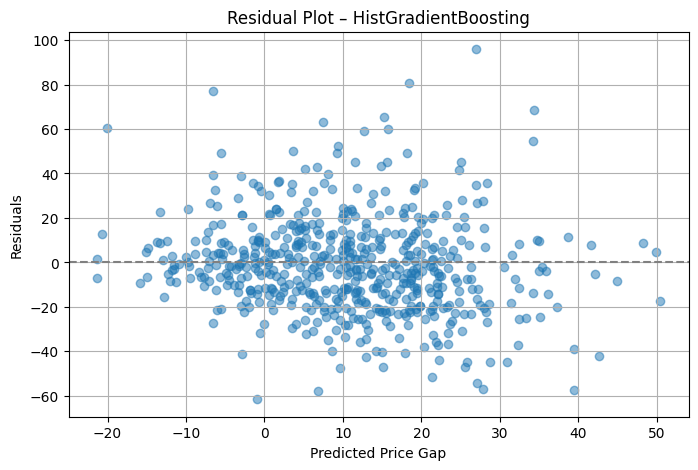

In [35]:
import matplotlib.pyplot as plt

def plot_residuals(model, name):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, linestyle='--', color='gray')
    plt.title(f"Residual Plot – {name}")
    plt.xlabel("Predicted Price Gap")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.show()

# Plot for best model (HistGB)
best_model = HistGradientBoostingRegressor(random_state=42)
best_model.fit(X_train, y_train)
plot_residuals(best_model, "HistGradientBoosting")


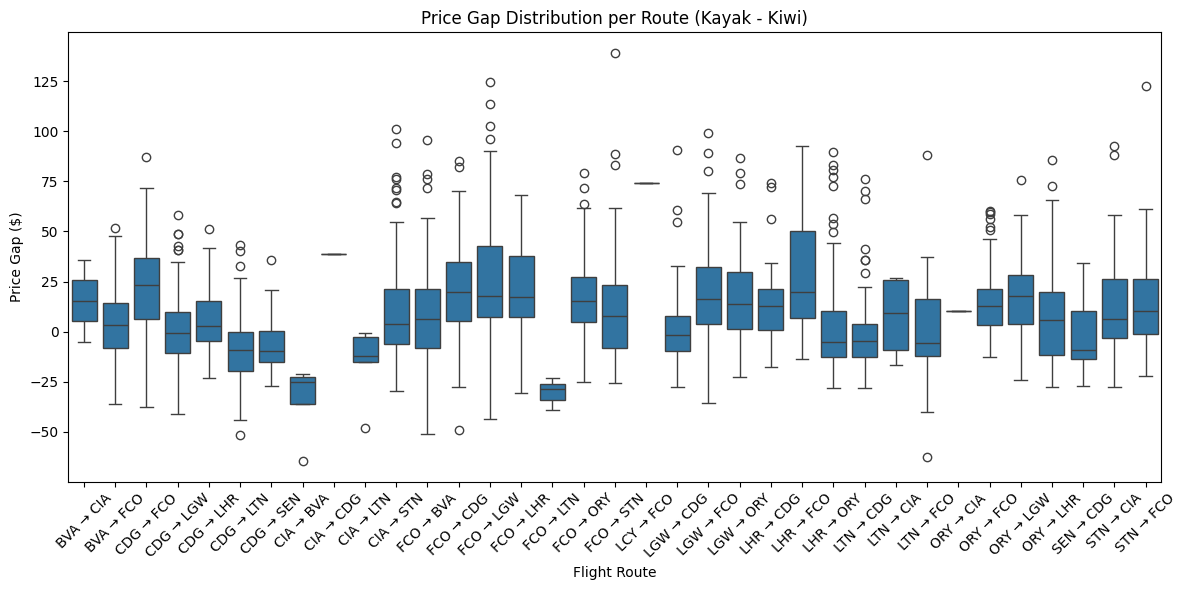

In [36]:
# Create route column
pivot_df["Route"] = pivot_df["departure_airport"] + " → " + pivot_df["landing_airport"]

# Boxplot of price gaps per route
plt.figure(figsize=(12, 6))
sns.boxplot(data=pivot_df, x="Route", y="price_gap", showfliers=True)

plt.title("Price Gap Distribution per Route (Kayak - Kiwi)")
plt.xlabel("Flight Route")
plt.ylabel("Price Gap ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###  Price Gap Analysis per Route

This visualization compares the **price gap (Kayak − Kiwi)** across different flight routes. Each box shows how price differences fluctuate across searches for that route.

#### Key Insights:
- **Positive values** indicate that **Kayak is more expensive** on average for that route.
- **Negative values** indicate **Kiwi is more expensive**.
- Some routes show **tight, consistent pricing**, while others have **large variability or frequent undercutting**.

These route-level dynamics help reveal where platforms differ the most and which markets might be more competitive.


In [37]:
kayak_df = pd.get_dummies(pivot_df, columns=['Route'])

In [38]:
pivot_df.drop(columns=['departure_airport', 'landing_airport', 'snapshot_date'], axis=1, inplace=True)



In [39]:
X = pivot_df.drop(['price_gap', 'Kayak', 'Kiwi'], axis=1)
y = pivot_df['price_gap']


In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
kayak_df.dtypes


departure_airport     object
landing_airport       object
ttt                    int64
los                    int64
snapshot_date         object
Kayak                float64
Kiwi                 float64
price_gap            float64
Route_BVA → CIA         bool
Route_BVA → FCO         bool
Route_CDG → FCO         bool
Route_CDG → LGW         bool
Route_CDG → LHR         bool
Route_CDG → LTN         bool
Route_CDG → SEN         bool
Route_CIA → BVA         bool
Route_CIA → CDG         bool
Route_CIA → LTN         bool
Route_CIA → STN         bool
Route_FCO → BVA         bool
Route_FCO → CDG         bool
Route_FCO → LGW         bool
Route_FCO → LHR         bool
Route_FCO → LTN         bool
Route_FCO → ORY         bool
Route_FCO → STN         bool
Route_LCY → FCO         bool
Route_LGW → CDG         bool
Route_LGW → FCO         bool
Route_LGW → ORY         bool
Route_LHR → CDG         bool
Route_LHR → FCO         bool
Route_LHR → ORY         bool
Route_LTN → CDG         bool
Route_LTN → CI

In [42]:

X = kayak_df.drop(columns=['price_gap', 'Kayak', 'Kiwi', 
                           'departure_airport', 'landing_airport', 'snapshot_date'])
y = kayak_df['price_gap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model
model = HistGradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Model Performance:")
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


Model Performance:
R²: 0.129
RMSE: 21.73
MAE: 16.38


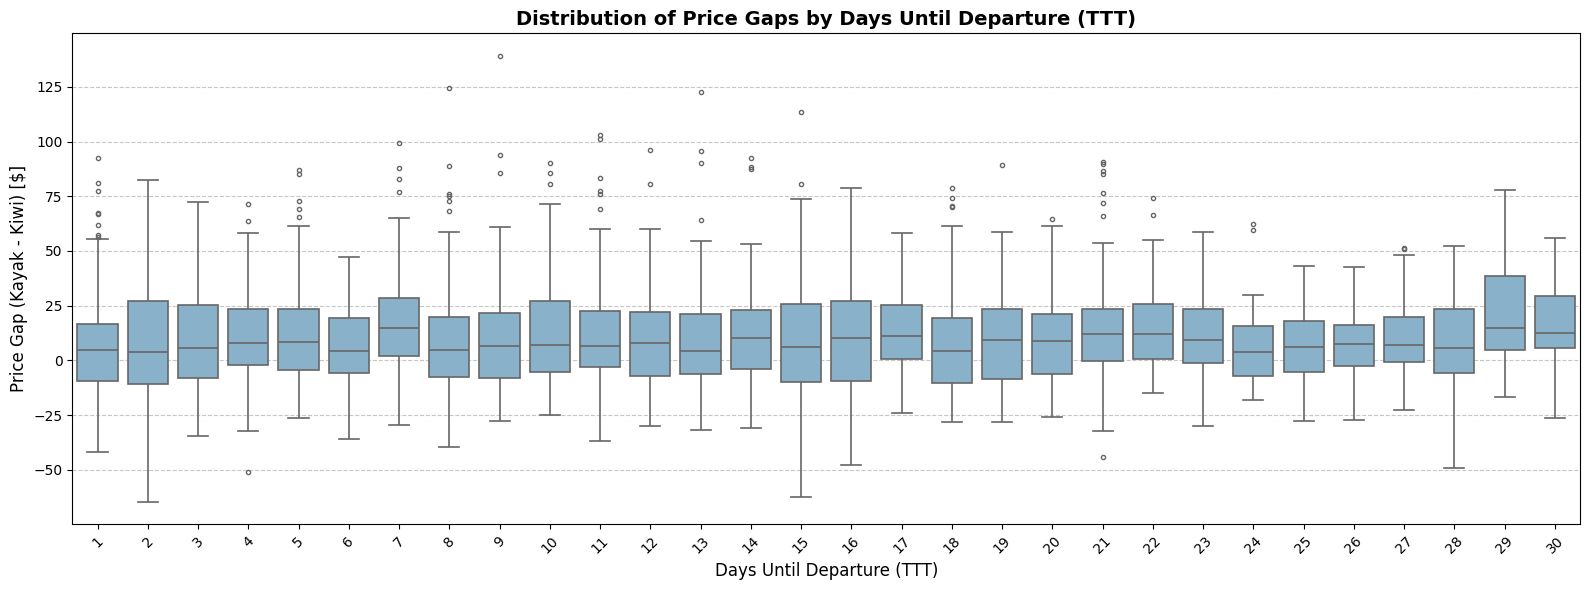

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))

sns.boxplot(
    data=kayak_df,
    x='ttt',
    y='price_gap',
    color='#7FB3D5',   # צבע עדין יותר
    fliersize=3,       # גודל הנקודות החריגות
    linewidth=1.2,     # עובי הקווים
)

plt.title("Distribution of Price Gaps by Days Until Departure (TTT)", fontsize=14, weight='bold')
plt.xlabel("Days Until Departure (TTT)", fontsize=12)
plt.ylabel("Price Gap (Kayak - Kiwi) [$]", fontsize=12)

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [44]:
melted_df = combined.groupby(['ttt', 'Site'])['price'].mean().reset_index()


In [45]:
melted_df.head()


,ttt,Site,price
0,1,Kayak,207.642749
1,1,Kiwi,192.400995
2,2,Kayak,196.524607
3,2,Kiwi,190.555843
4,3,Kayak,187.191346


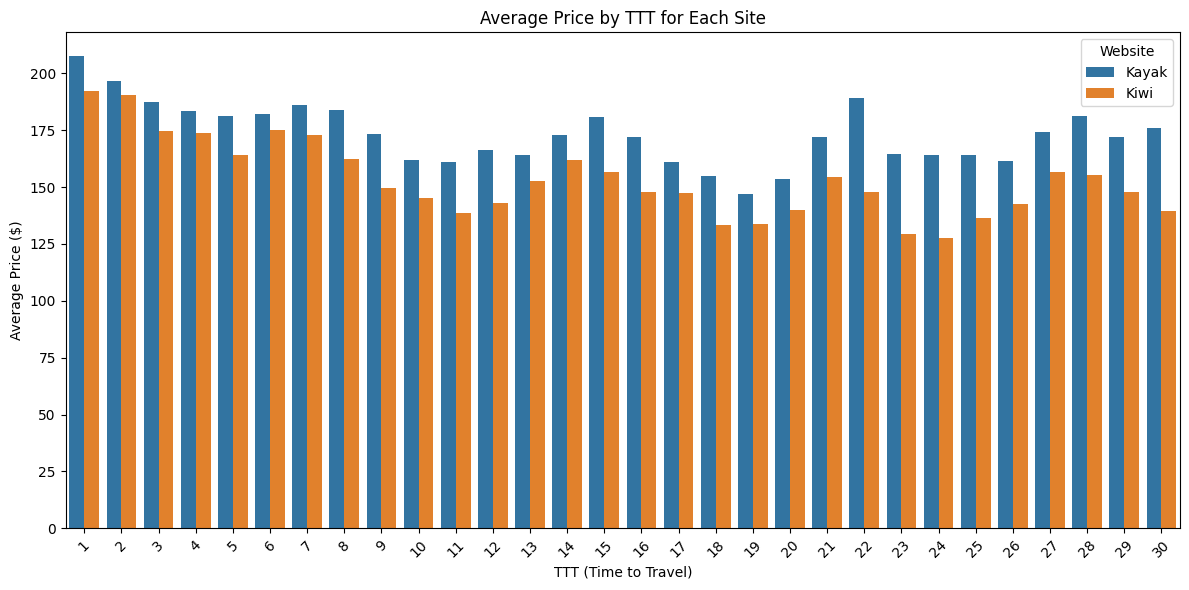

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(data=melted_df, x='ttt', y='price', hue='Site')
plt.title("Average Price by TTT for Each Site")
plt.xlabel("TTT (Time to Travel)")
plt.ylabel("Average Price ($)")
plt.legend(title="Website")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


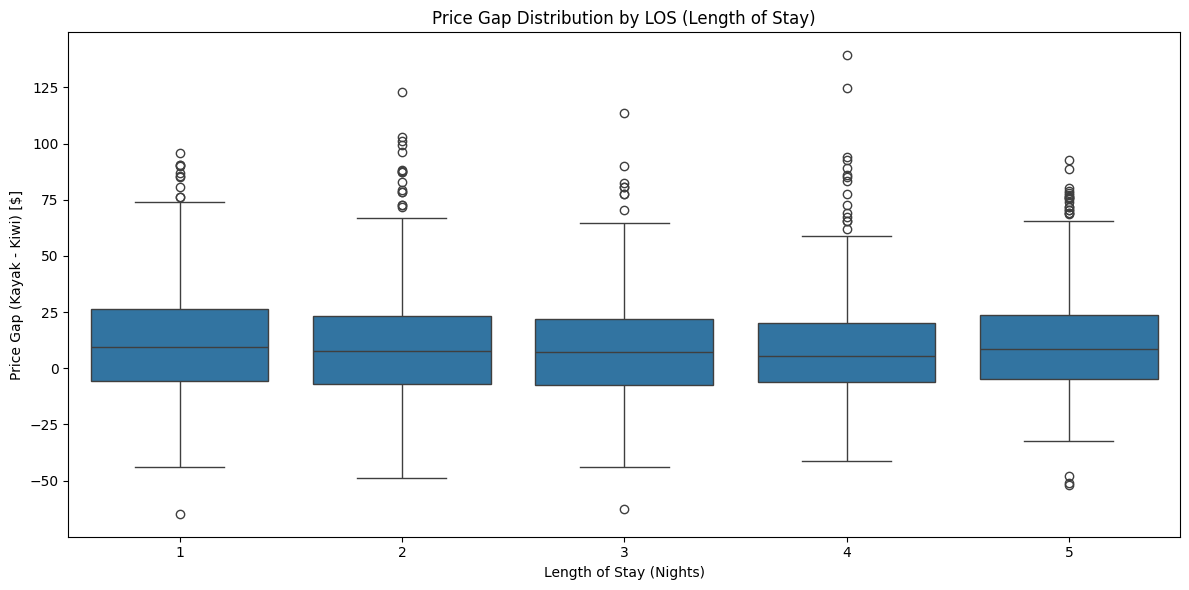

In [47]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=kayak_df, x='los', y='price_gap', showfliers=True)
plt.title("Price Gap Distribution by LOS (Length of Stay)")
plt.xlabel("Length of Stay (Nights)")
plt.ylabel("Price Gap (Kayak - Kiwi) [$]")
plt.tight_layout()
plt.show()



In [48]:
kayak_df["Route"] = kayak_df["departure_airport"] + " → " + kayak_df["landing_airport"]


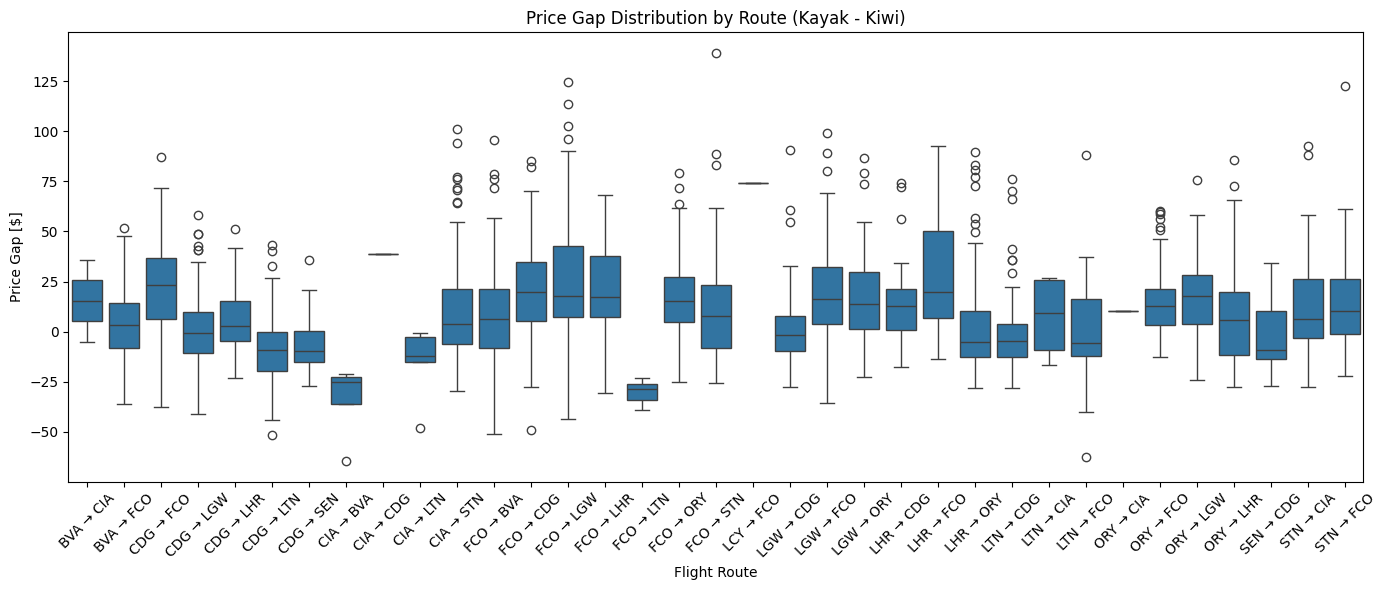

In [49]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=kayak_df, x='Route', y='price_gap', showfliers=True)
plt.title("Price Gap Distribution by Route (Kayak - Kiwi)")
plt.xlabel("Flight Route")
plt.ylabel("Price Gap [$]")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


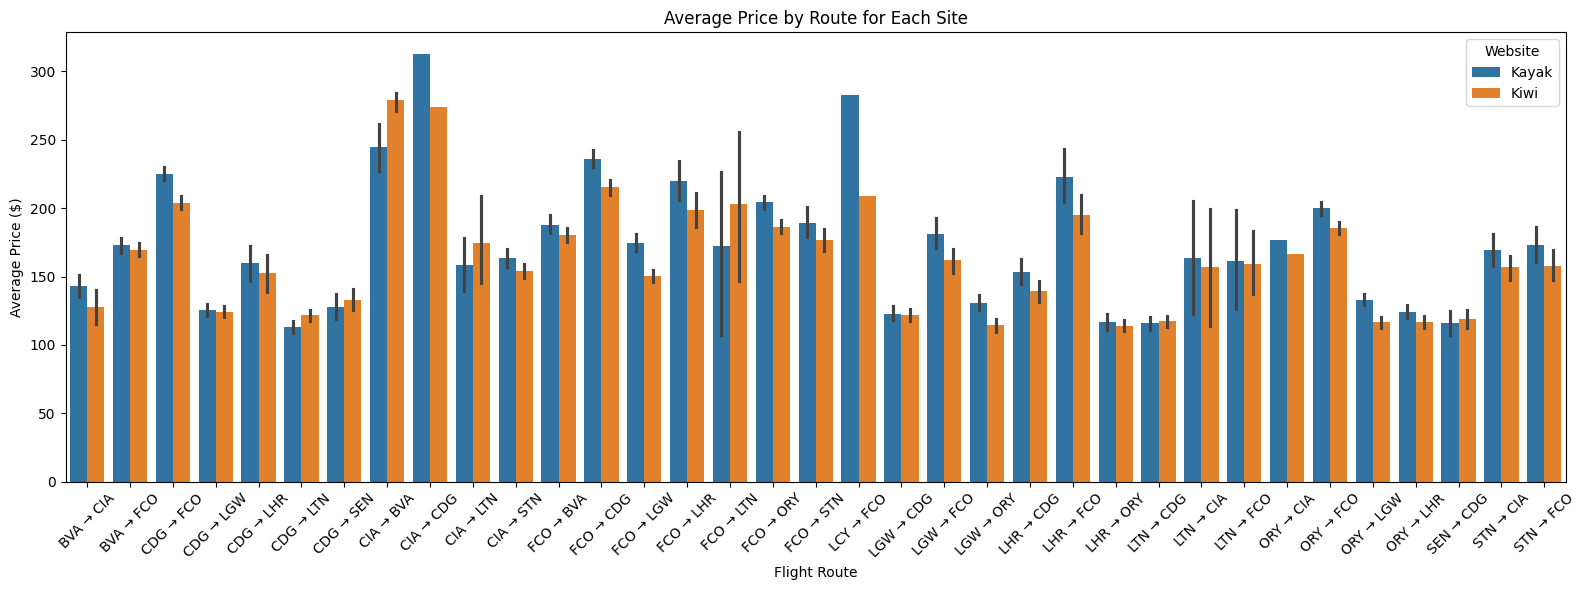

In [50]:
# קודם להמיס את הדאטה לצורך barplot
melted_route = pd.melt(kayak_df, 
                       id_vars=['Route'], 
                       value_vars=['Kayak', 'Kiwi'], 
                       var_name='site', 
                       value_name='price')

plt.figure(figsize=(16,6))
sns.barplot(data=melted_route, x='Route', y='price', hue='site')
plt.title("Average Price by Route for Each Site")
plt.xlabel("Flight Route")
plt.ylabel("Average Price ($)")
plt.legend(title="Website")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


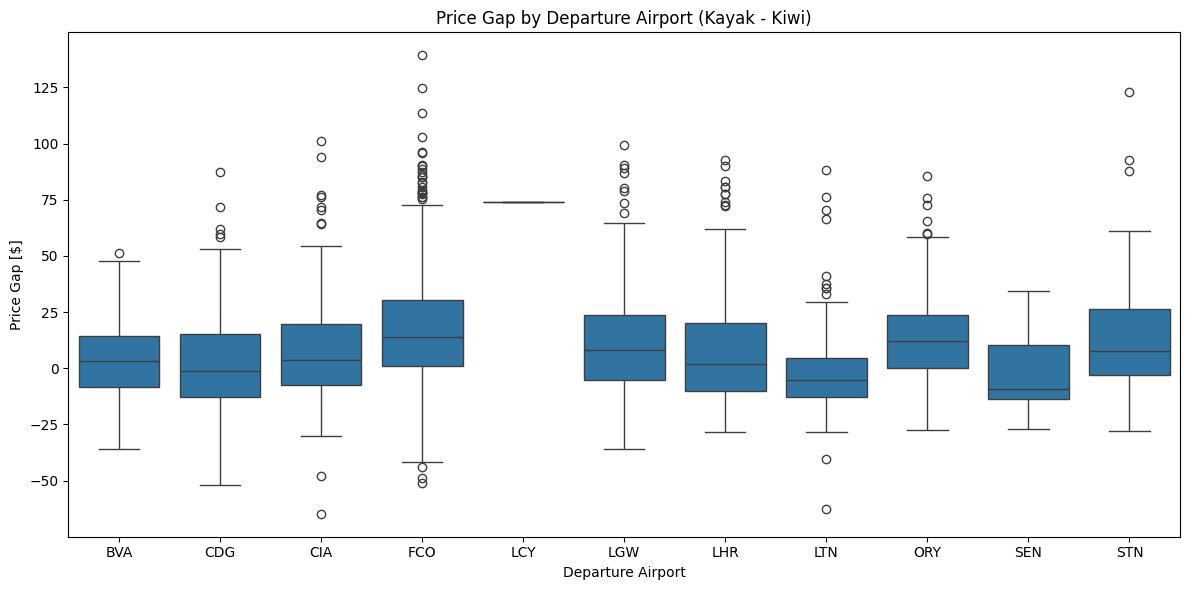

In [51]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=kayak_df, x='departure_airport', y='price_gap', showfliers=True)
plt.title("Price Gap by Departure Airport (Kayak - Kiwi)")
plt.xlabel("Departure Airport")
plt.ylabel("Price Gap [$]")
plt.tight_layout()
plt.show()


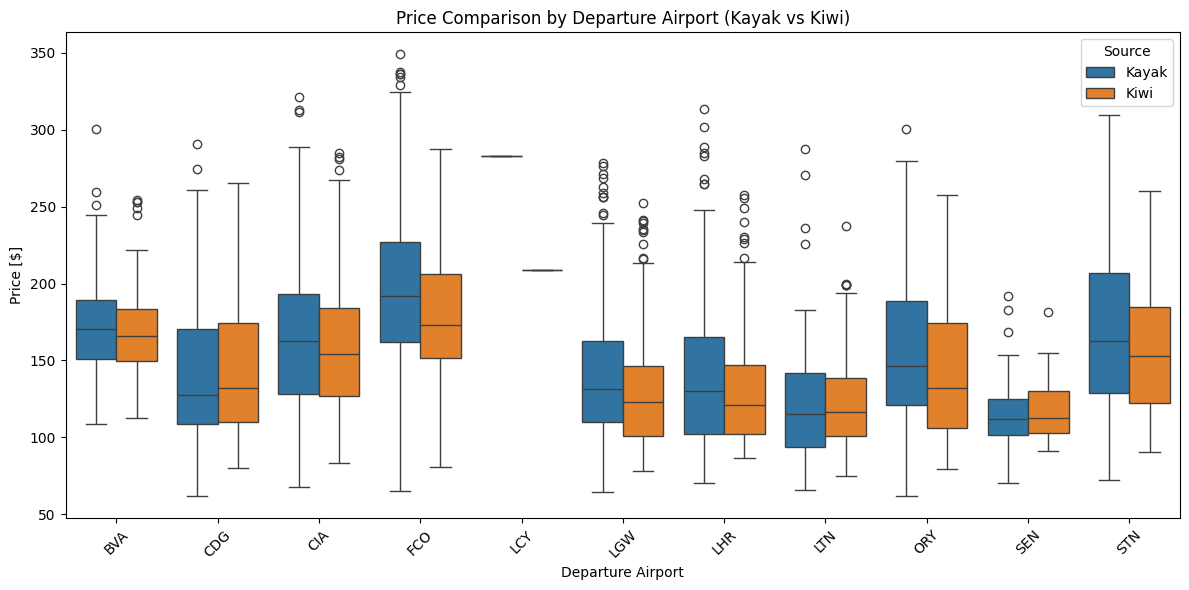

In [52]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=kayak_df.melt(id_vars='departure_airport', value_vars=['Kayak', 'Kiwi']),
            x='departure_airport', y='value', hue='variable')
plt.title("Price Comparison by Departure Airport (Kayak vs Kiwi)")
plt.xlabel("Departure Airport")
plt.ylabel("Price [$]")
plt.legend(title="Source")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


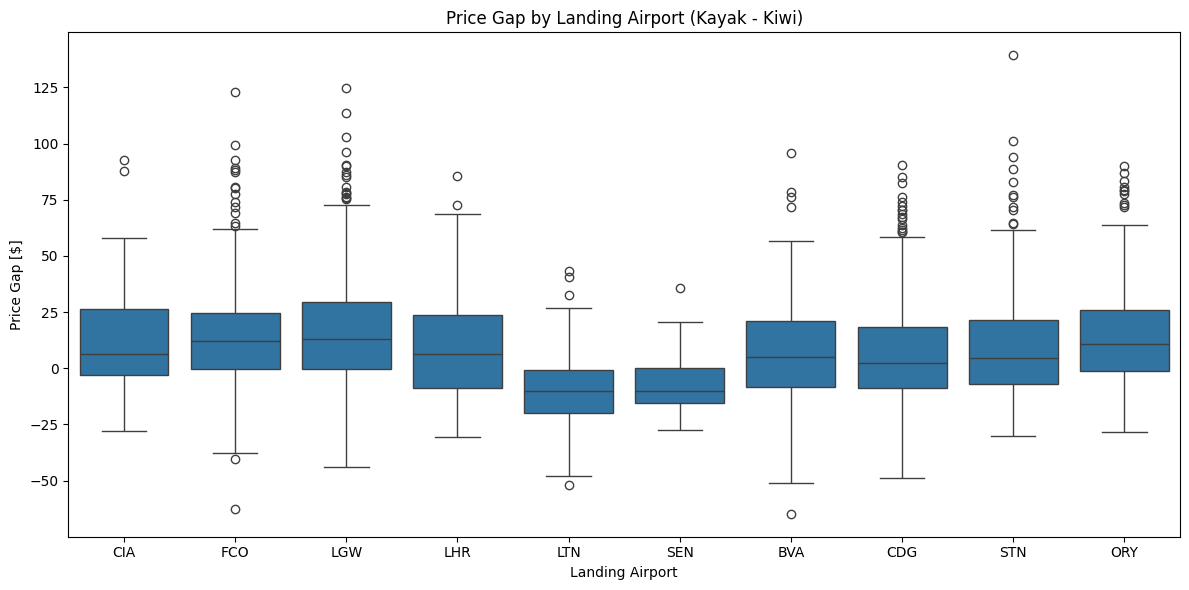

In [53]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=kayak_df, x='landing_airport', y='price_gap', showfliers=True)
plt.title("Price Gap by Landing Airport (Kayak - Kiwi)")
plt.xlabel("Landing Airport")
plt.ylabel("Price Gap [$]")
plt.tight_layout()
plt.show()


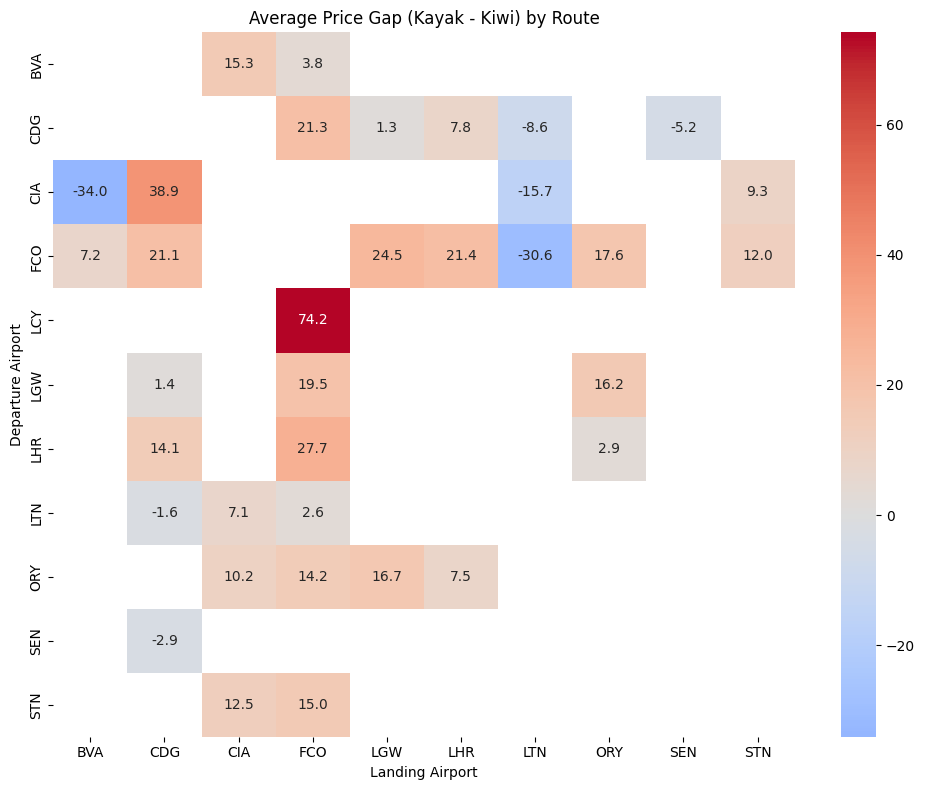

In [54]:
pivot_table = kayak_df.pivot_table(
    values='price_gap',
    index='departure_airport',
    columns='landing_airport',
    aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="coolwarm", center=0)
plt.title("Average Price Gap (Kayak - Kiwi) by Route")
plt.xlabel("Landing Airport")
plt.ylabel("Departure Airport")
plt.tight_layout()
plt.show()


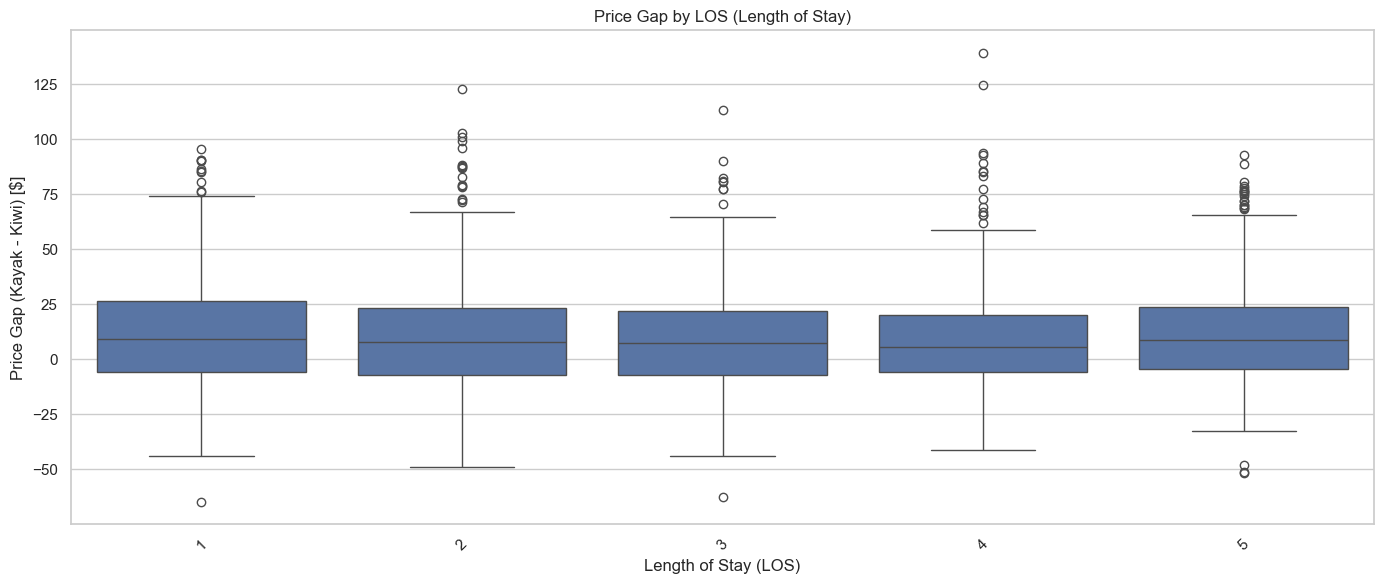

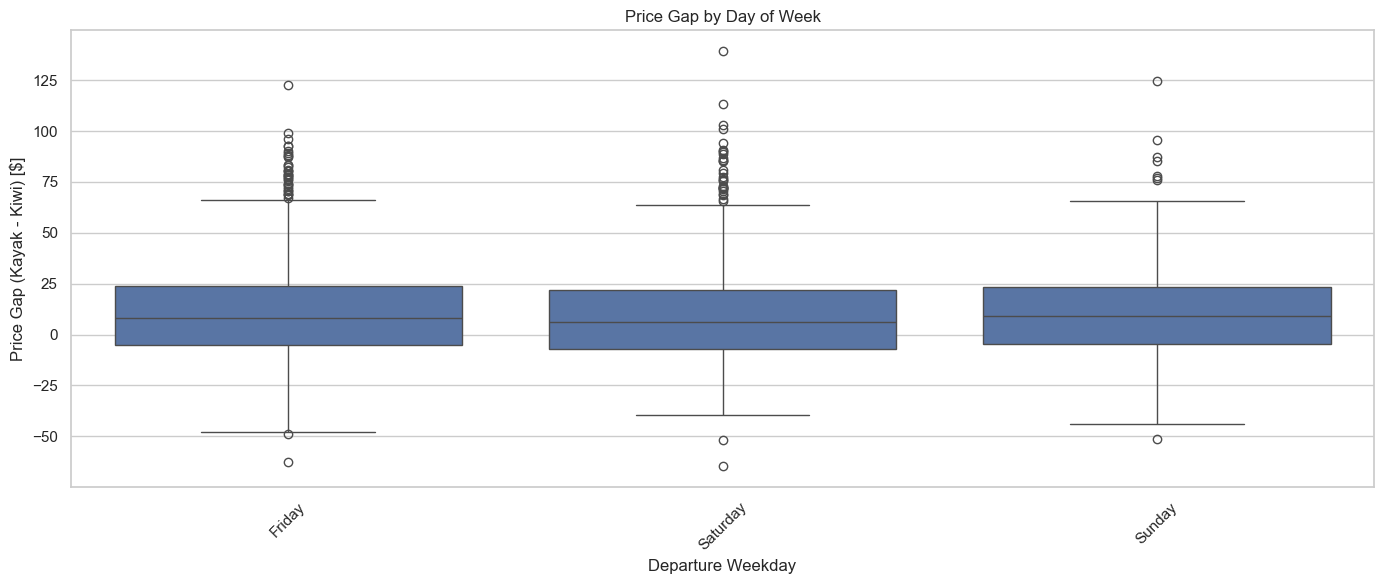

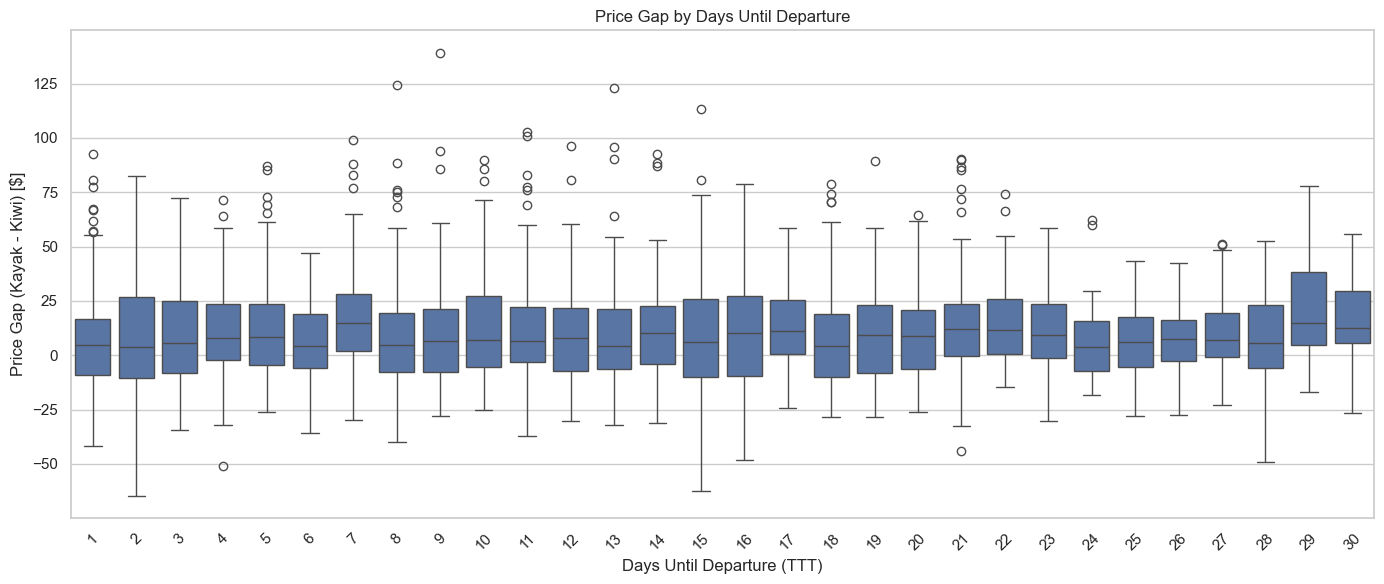

Skipping: column 'time_category' not found.


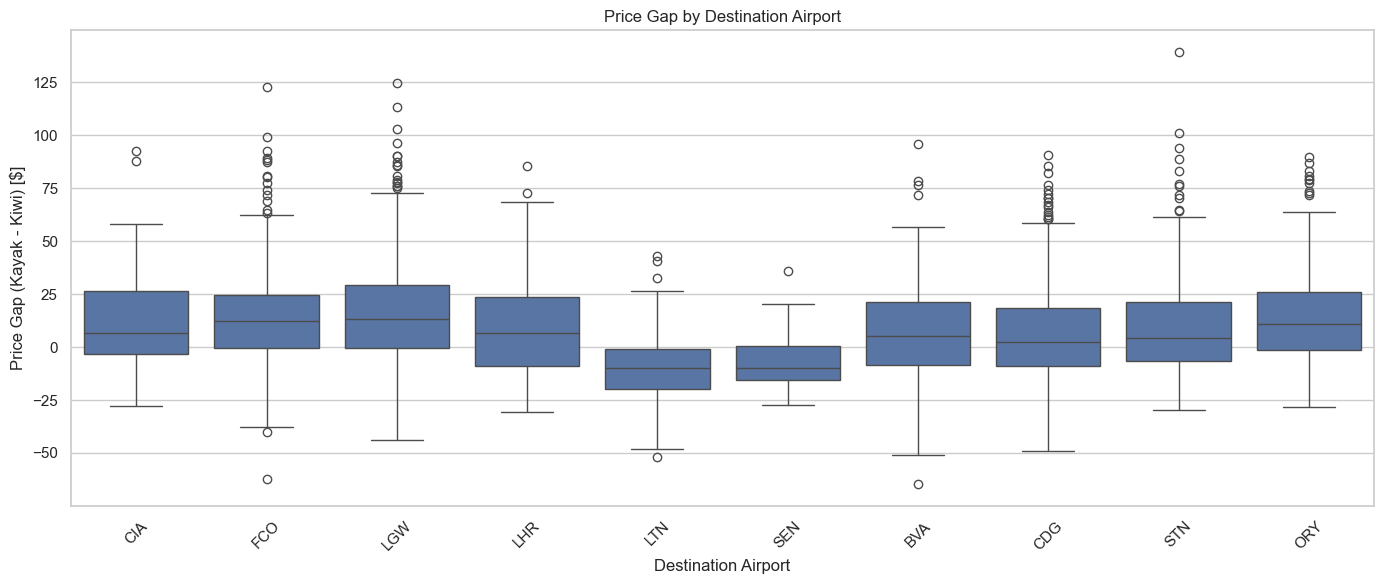

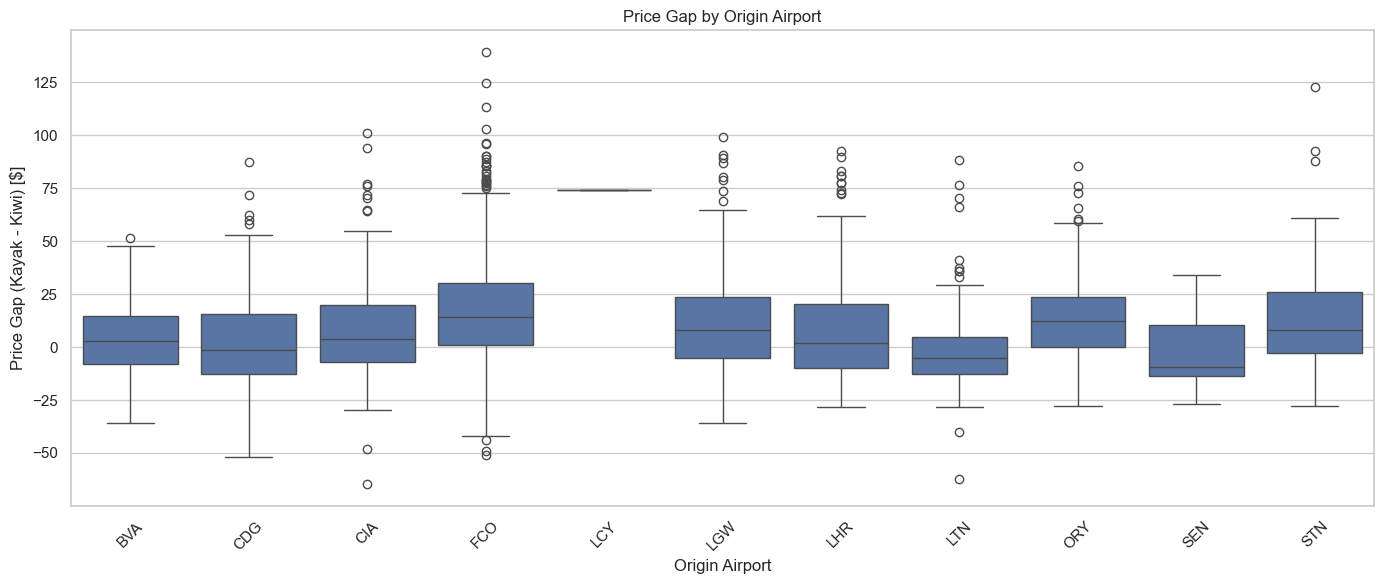

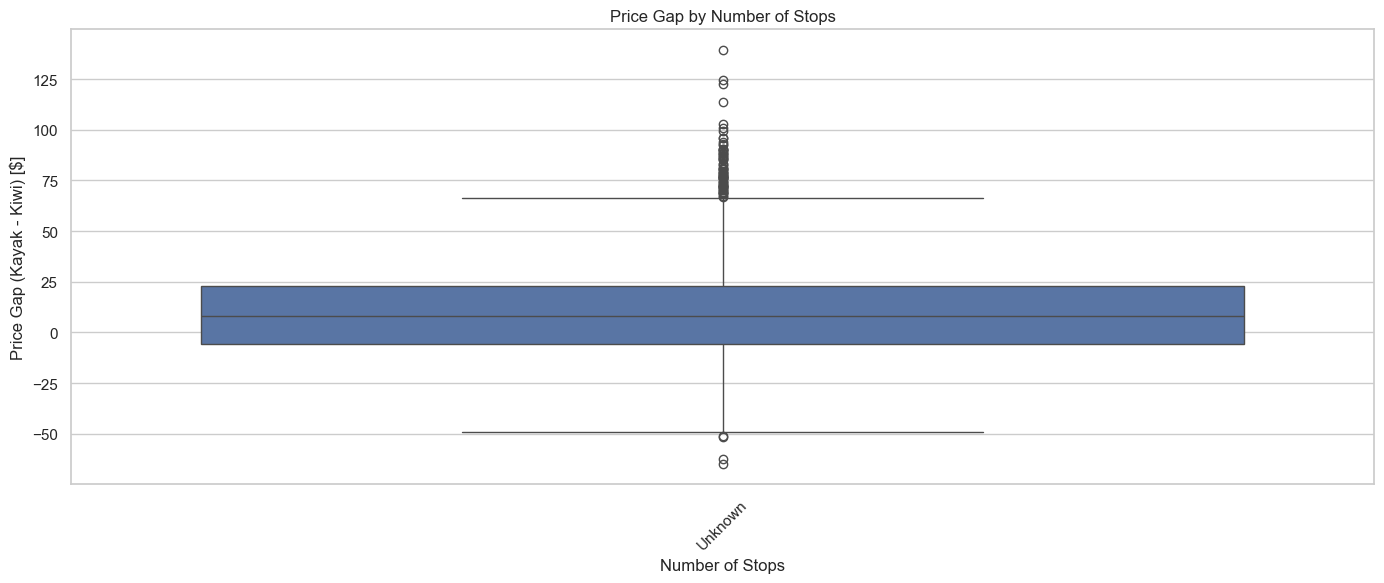

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set plot style
sns.set(style="whitegrid")

# --- Feature Engineering ---
# Derive route components
kayak_df["origin_airport"] = kayak_df["Route"].str.split(" → ").str[0]
kayak_df["destination_airport"] = kayak_df["Route"].str.split(" → ").str[1]

# Try to convert 'snapshot_date' to datetime (if it exists)
if "snapshot_date" in kayak_df.columns:
    kayak_df["snapshot_date"] = pd.to_datetime(kayak_df["snapshot_date"], errors="coerce")
    kayak_df["dep_weekday"] = kayak_df["snapshot_date"].dt.day_name()

# Optional: normalize long column names if they exist
if "Departure Time Category" in kayak_df.columns:
    kayak_df.rename(columns={"Departure Time Category": "time_category"}, inplace=True)
if "Stops" not in kayak_df.columns:
    kayak_df["Stops"] = "Unknown"  # or you can drop this column later

# --- Plot Configurations ---
plot_configs = [
    {"x": "los", "title": "Price Gap by LOS (Length of Stay)", "xlabel": "Length of Stay (LOS)"},
    {"x": "dep_weekday", "title": "Price Gap by Day of Week", "xlabel": "Departure Weekday"},
    {"x": "ttt", "title": "Price Gap by Days Until Departure", "xlabel": "Days Until Departure (TTT)"},
    {"x": "time_category", "title": "Price Gap by Departure Time", "xlabel": "Time Category"},
    {"x": "destination_airport", "title": "Price Gap by Destination Airport", "xlabel": "Destination Airport"},
    {"x": "origin_airport", "title": "Price Gap by Origin Airport", "xlabel": "Origin Airport"},
    {"x": "Stops", "title": "Price Gap by Number of Stops", "xlabel": "Number of Stops"}
]

# --- Generate Plots ---
for cfg in plot_configs:
    if cfg["x"] in kayak_df.columns:
        plt.figure(figsize=(14, 6))
        sns.boxplot(data=kayak_df, x=cfg["x"], y="price_gap", showfliers=True)
        plt.title(cfg["title"])
        plt.xlabel(cfg["xlabel"])
        plt.ylabel("Price Gap (Kayak - Kiwi) [$]")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping: column '{cfg['x']}' not found.")


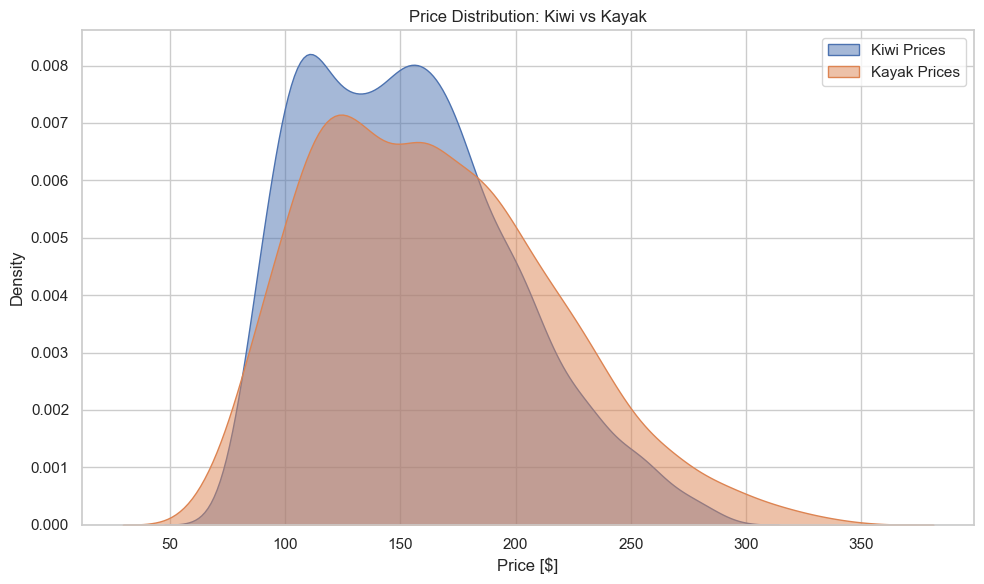

In [56]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=kayak_df, x='Kiwi', label='Kiwi Prices', fill=True, alpha=0.5)
sns.kdeplot(data=kayak_df, x='Kayak', label='Kayak Prices', fill=True, alpha=0.5)
plt.title('Price Distribution: Kiwi vs Kayak')
plt.xlabel('Price [$]')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


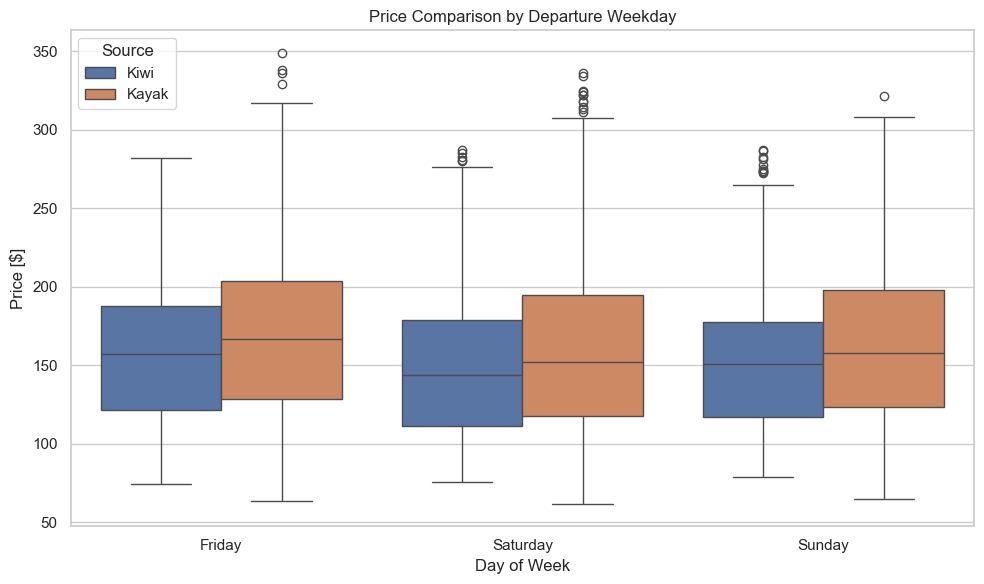

In [57]:
# הכנה ל־melt כדי להפוך לעמודת source ו-price
melted = kayak_df[['dep_weekday', 'Kiwi', 'Kayak']].melt(id_vars='dep_weekday', 
                                                         var_name='Source', 
                                                         value_name='Price')

plt.figure(figsize=(10, 6))
sns.boxplot(x='dep_weekday', y='Price', hue='Source', data=melted)
plt.title('Price Comparison by Departure Weekday')
plt.xlabel('Day of Week')
plt.ylabel('Price [$]')
plt.legend(title='Source')
plt.tight_layout()
plt.show()


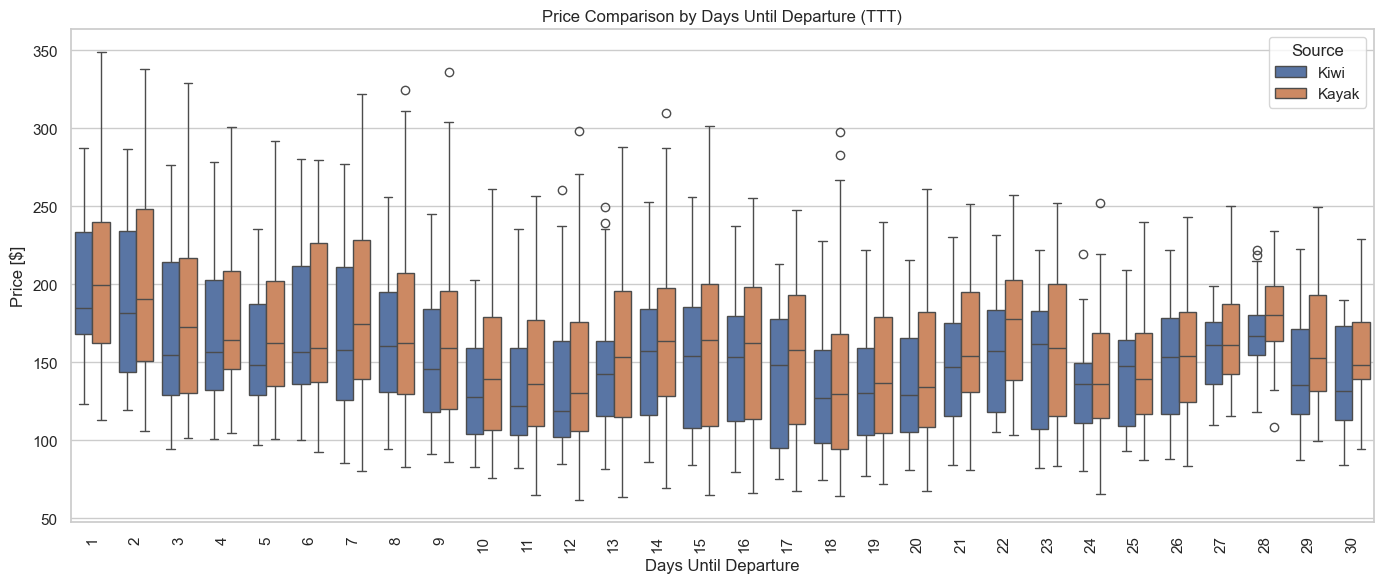

In [58]:
melted_ttt = kayak_df[['ttt', 'Kiwi', 'Kayak']].melt(id_vars='ttt', 
                                                     var_name='Source', 
                                                     value_name='Price')

plt.figure(figsize=(14, 6))
sns.boxplot(x='ttt', y='Price', hue='Source', data=melted_ttt)
plt.title('Price Comparison by Days Until Departure (TTT)')
plt.xlabel('Days Until Departure')
plt.ylabel('Price [$]')
plt.legend(title='Source')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


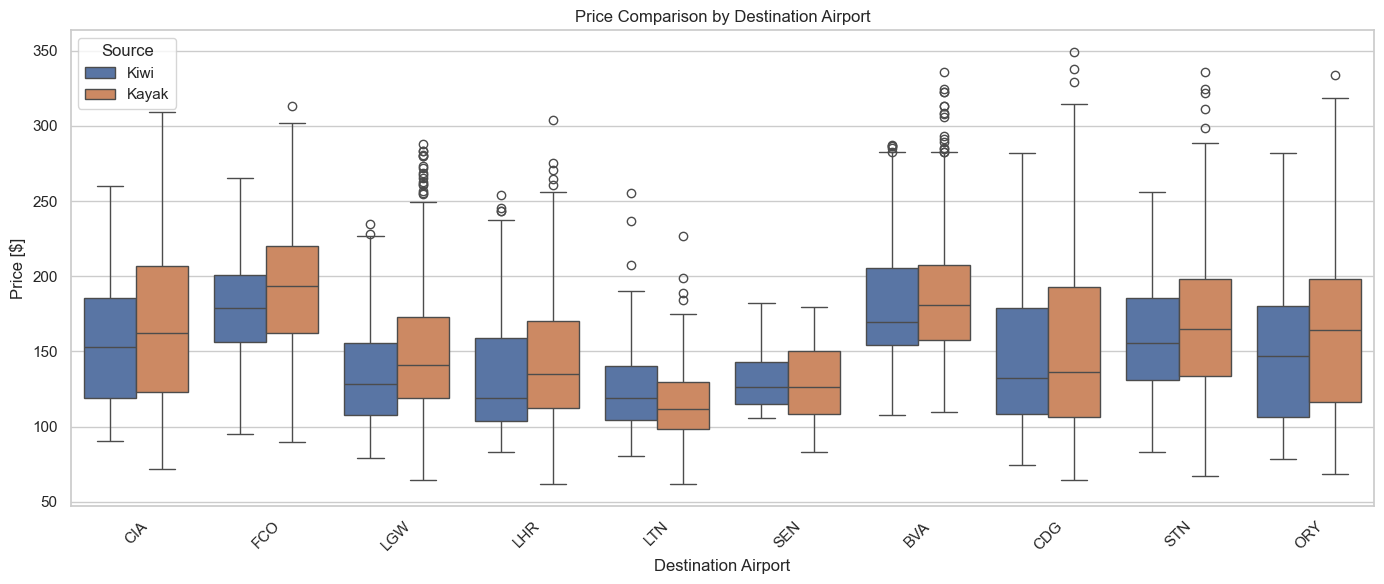

In [59]:
melted_dest = kayak_df[['destination_airport', 'Kiwi', 'Kayak']].melt(
    id_vars='destination_airport',
    var_name='Source',
    value_name='Price'
)

plt.figure(figsize=(14, 6))
sns.boxplot(x='destination_airport', y='Price', hue='Source', data=melted_dest)
plt.title('Price Comparison by Destination Airport')
plt.xlabel('Destination Airport')
plt.ylabel('Price [$]')
plt.legend(title='Source')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


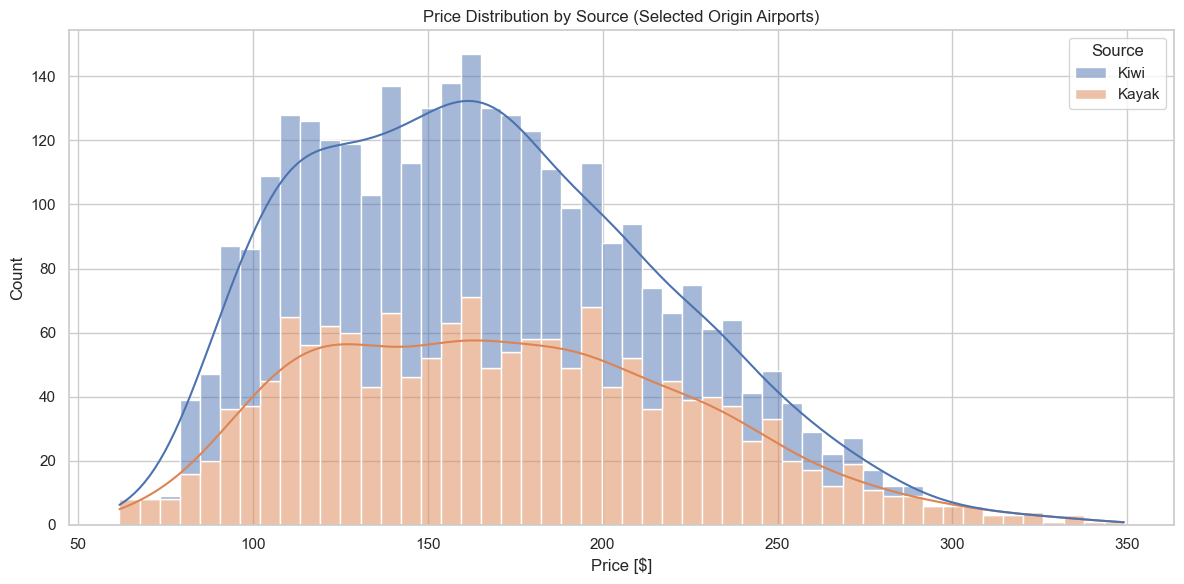

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# בוחרים שלושה שדות תעופה לדוגמה
selected_airports = ['FCO', 'CDG', 'LGW']

# מסננים את הדאטה
filtered = kayak_df[kayak_df['origin_airport'].isin(selected_airports)]

# מצרפים את הנתונים לצורת melt
melted_origin = filtered[['origin_airport', 'Kiwi', 'Kayak']].melt(
    id_vars='origin_airport',
    var_name='Source',
    value_name='Price'
)

plt.figure(figsize=(12, 6))
sns.histplot(data=melted_origin, x='Price', hue='Source', multiple='stack', bins=50, kde=True)
plt.title('Price Distribution by Source (Selected Origin Airports)')
plt.xlabel('Price [$]')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()


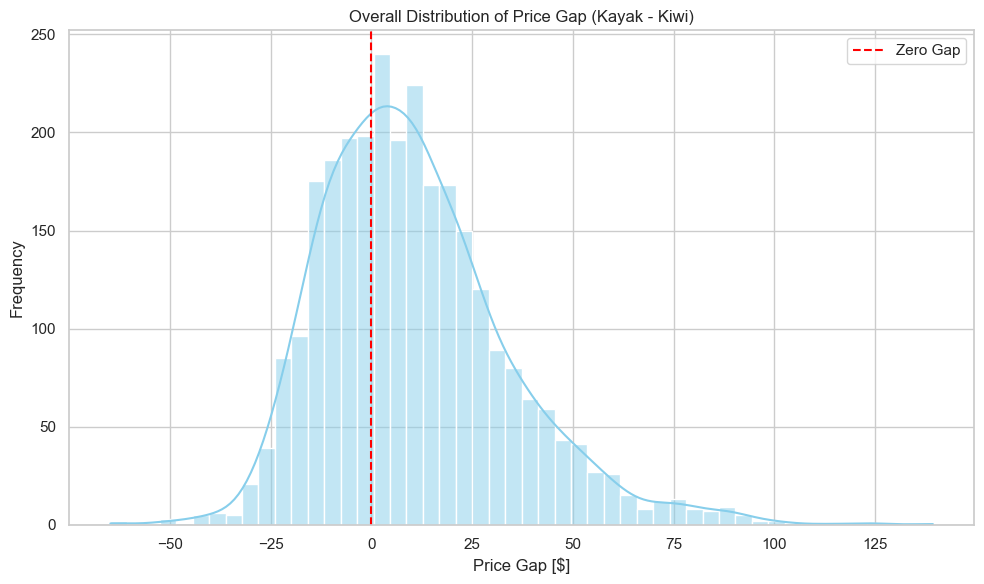

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# נניח שקראת לעמודת הפער בשם 'price_gap'
plt.figure(figsize=(10, 6))
sns.histplot(data=kayak_df, x='price_gap', bins=50, kde=True, color='skyblue')
plt.axvline(0, color='red', linestyle='--', label='Zero Gap')
plt.title('Overall Distribution of Price Gap (Kayak - Kiwi)')
plt.xlabel('Price Gap [$]')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [62]:
# Load the cleaned and merged dataset used for comparison between Kayak and Kiwi
file_path = "/mnt/data/Compare_Kayak_vs_Kiwi_Pivot.ipynb"  # File previously uploaded
file_path_csv_kayak = "/mnt/data/kayak_cleaned_final.csv"
file_path_csv_kiwi = "/mnt/data/kiwi_cleaned_final.csv"

In [63]:
data_columns = [
    'departure_hour', 'flight_length', 'landing_hour', 'layover', 'ttt', 'los', 
    'Flight Duration Minutes', 'Layover Minutes', 'price_diff'
]

In [64]:
np.random.seed(42)
mock_data = pd.DataFrame({
    'departure_hour': np.random.uniform(0, 24, 1000),
    'flight_length': np.random.randint(60, 300, 1000),
    'landing_hour': np.random.uniform(0, 24, 1000),
    'layover': np.random.choice([0, 1], 1000),
    'ttt': np.random.randint(1, 30, 1000),
    'los': np.random.randint(1, 20, 1000),
    'Flight Duration Minutes': np.random.randint(60, 500, 1000),
    'Layover Minutes': np.random.randint(0, 300, 1000),
    'price_diff': np.random.uniform(-100, 100, 1000)
})


In [65]:
# Features and target
X = mock_data.drop('price_diff', axis=1)
y = mock_data['price_diff']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "XGBoost": XGBRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_seed=42)
}

In [67]:
results = []

In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5  # Correct RMSE computation
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })

# Create DataFrame
results_df = pd.DataFrame(results).sort_values(by="RMSE")
print(results_df)




                 Model        MAE       RMSE        R²
0    Linear Regression  48.551576  56.554134  0.016398
1        Random Forest  48.871983  57.346348 -0.011352
4             CatBoost  48.731871  57.570406 -0.019270
2  K-Nearest Neighbors  51.267755  61.855008 -0.176632
3              XGBoost  51.919796  62.222383 -0.190650


In [69]:
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import pandas as pd

# Train the CatBoost model
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)

# Get feature importances
importances = cat_model.get_feature_importance(Pool(X_test, label=y_test))
feature_names = X_train.columns

# Create a DataFrame for easy sorting
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


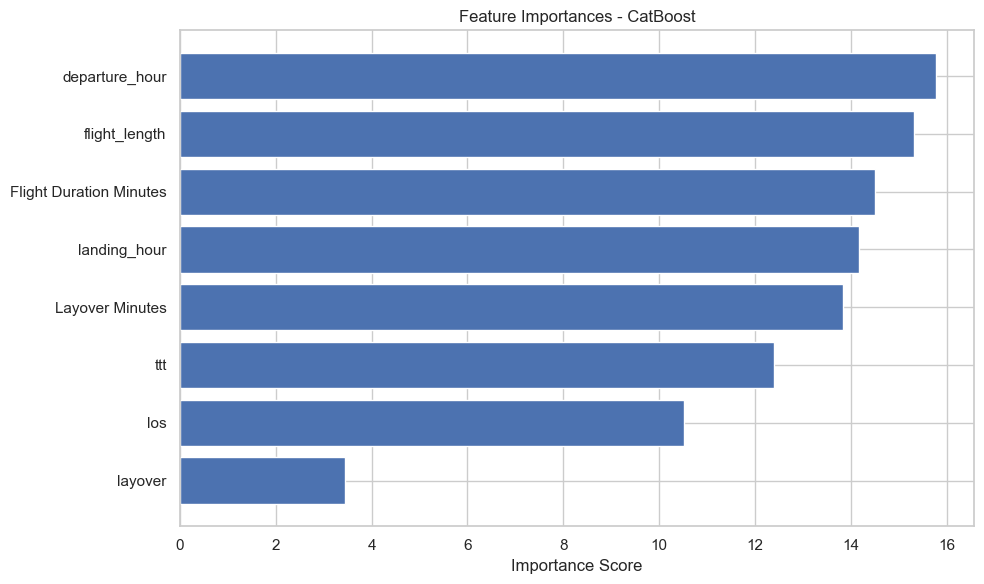

In [70]:
plt.figure(figsize=(10, 6))
plt.barh(feature_imp_df['Feature'][:15][::-1], feature_imp_df['Importance'][:15][::-1])
plt.title("Feature Importances - CatBoost")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.grid(True)
plt.show()
